`data_retrieval` assigned State type: DataState
`data_cleaning` assigned State type: DataState
`news_sentiment` assigned State type: FinanceState
`market_trend` assigned State type: FinanceState
`investment_strategy` assigned State type: FinanceState
`report_generation` assigned State type: ReportState
`summary_extraction` assigned State type: ReportState


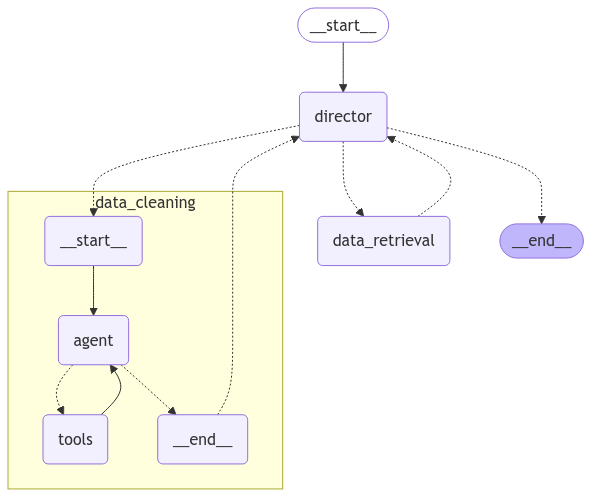

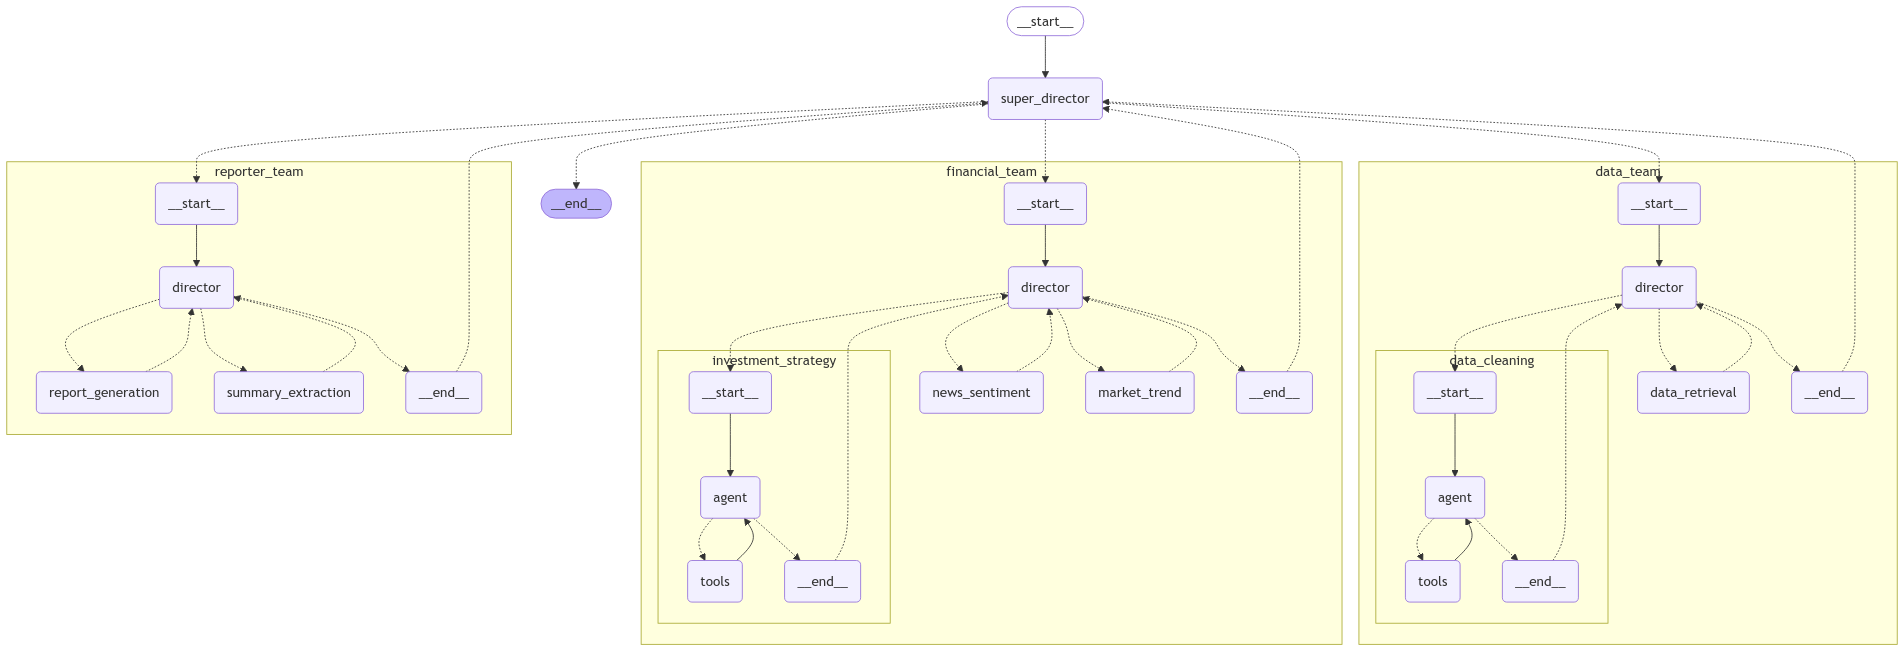

In [1]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
from pydantic import BaseModel
# from typing import TypedDict, List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Any 
from typing import TypedDict, List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic


# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor

# LangGraph 관련 라이브러리
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

from agents.agent_library import agent_configs, AgentConfig

# 환경 변수 로드
load_dotenv()


# Environment variables
groq_api_key = os.getenv("GROQ_API_KEY")
MODEL_NAME = "gemma2-9b-it"

# State definitions
class DataState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

class FinanceState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

class ReportState(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

T = TypeVar("T", DataState, FinanceState, ReportState, State)

agent_state_map: Dict[str, Type] = {
    "data_retrieval": DataState,
    "data_cleaning": DataState,
    "news_sentiment": FinanceState,
    "market_trend": FinanceState,
    "investment_strategy": FinanceState,
    "report_generation": ReportState,
    "summary_extraction": ReportState,
}

# Supervisor node factory
def make_supervisor_node(
    model_name: str,
    members: List[str],
    system_prompt: str,
    state_type: Type[T]
) -> Callable[[T], Command]:
    
    options_for_next = ["FINISH"] + members
    class Router(TypedDict):
        next: Literal[*options_for_next]

    def supervisor_node(state: T) -> Command[Literal[*members, "__end__"]]:
        if not isinstance(state, state_type):
            raise TypeError(f"⚠ `state` is not the expected type. Expected: {state_type.__name__}, Got: {type(state).__name__}")
        
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        
        llm = ChatGroq(
            model=model_name,
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
        )

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        
        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})
    
    return supervisor_node

# Agent factory
class AgentMaker(Generic[T]):
    def __init__(self, model_name: str, agent_configs: Dict[str, AgentConfig], agent_state_map: Dict[str, Type[T]]):
        self.llm = ChatGroq(model=model_name, temperature=0)
        self.agent_configs = agent_configs
        self.agent_state_map = agent_state_map

    def create_agent(self, config: AgentConfig):
        prompt = ChatPromptTemplate.from_template(config["prompt"]) if config.get("prompt") else ChatPromptTemplate.from_template("You are an agent. Respond to: {input}")
        return create_react_agent(self.llm, tools=config["tools"], prompt=prompt)

    def create_agent_node(self, agent, name: str, state_type: Type[T]) -> Callable[[T], Command]:
        def agent_node(state: T) -> Command[Literal["director"]]:
            if not isinstance(state, state_type):
                raise TypeError(f"`state` is not the expected type. Expected: {state_type.__name__}, Got: {type(state).__name__}")
            
            result = agent.invoke(state)  # Direct invoke without AgentExecutor
            return Command(
                update={
                    "messages": [
                        HumanMessage(content=result["messages"][-1].content, name=name)
                    ]
                },
                goto="director",
            )
        return agent_node

    def create_agent_and_node(self, name: str) -> Tuple[Type[T], Callable[[T], Command[Literal["director"]]]]:
        if name not in self.agent_configs:
            raise ValueError(f"'{name}' not found in agent_configs")
        if name not in self.agent_state_map:
            raise ValueError(f"'{name}' has no defined State type in agent_state_map")

        state_type = self.agent_state_map[name]
        print(f"`{name}` assigned State type: {state_type.__name__}")

        agent = self.create_agent(self.agent_configs[name])
        node = self.create_agent_node(agent, name, state_type)
        return agent, node

# Team and agent lists
team_node_list = ["data_team", "financial_team", "reporter_team"]
data_agent_node_list = ["data_retrieval", "data_cleaning"]
financial_agent_node_list = ["news_sentiment", "market_trend", "investment_strategy"]
reporter_agent_node_list = ["report_generation", "summary_extraction"]

# Prompts
team_director_system_prompt = f"""You are a director managing a conversation between the following teams: {team_node_list}.
Given the user request, respond with the team to act next. Each team will perform a task and return results.
When finished, respond with FINISH.
If data collection is required, assign the task to the data_team.
If financial analysis is needed, assign the task to the financial_team.
If report writing is necessary, assign the task to the reporter_team."""

data_director_system_prompt = f"""You are a director managing a conversation between the following workers: {data_agent_node_list}.
Given the user request, respond with the worker to act next. Each worker will perform a task and return results.
When finished, respond with FINISH."""

finance_director_system_prompt = f"""You are a director managing a conversation between the following workers: {financial_agent_node_list}.
Given the user request, respond with the worker to act next. Each worker will perform a task and return results.
When finished, respond with FINISH."""

reporter_director_system_prompt = f"""You are a director managing a conversation between the following workers: {reporter_agent_node_list}.
Given the user request, respond with the worker to act next. Each worker will perform a task and return results.
When finished, respond with FINISH."""

# Supervisor nodes
super_director_node = make_supervisor_node(MODEL_NAME, team_node_list, team_director_system_prompt, State)
data_director_agent_node = make_supervisor_node(MODEL_NAME, data_agent_node_list, data_director_system_prompt, DataState)
financial_director_agent_node = make_supervisor_node(MODEL_NAME, financial_agent_node_list, finance_director_system_prompt, FinanceState)
report_director_agent_node = make_supervisor_node(MODEL_NAME, reporter_agent_node_list, reporter_director_system_prompt, ReportState)

# Agent maker instance
agent_maker = AgentMaker(model_name=MODEL_NAME, agent_configs=agent_configs, agent_state_map=agent_state_map)

# Create agents and nodes
data_retrieval_agent, data_retrieval_node = agent_maker.create_agent_and_node("data_retrieval")
data_cleaning_agent, data_cleaning_node = agent_maker.create_agent_and_node("data_cleaning")
news_sentiment_agent, news_sentiment_node = agent_maker.create_agent_and_node("news_sentiment")
market_trend_agent, market_trend_node = agent_maker.create_agent_and_node("market_trend")
investment_strategy_agent, investment_strategy_node = agent_maker.create_agent_and_node("investment_strategy")
report_generation_agent, report_generation_node = agent_maker.create_agent_and_node("report_generation")
summary_extraction_agent, summary_extraction_node = agent_maker.create_agent_and_node("summary_extraction")


# data_team 워크플로우
data_builder = StateGraph(DataState)
data_builder.add_node("director", data_director_agent_node)
data_builder.add_node("data_retrieval", data_retrieval_node)
data_builder.add_node("data_cleaning", data_cleaning_node)

data_builder.add_edge(START, "director")
data_graph = data_builder.compile()

display(
    Image(
        data_graph.get_graph(xray=True).draw_mermaid_png()
    )
)


finacial_builder = StateGraph(FinanceState)
finacial_builder.add_node("director", financial_director_agent_node)
finacial_builder.add_node("news_sentiment", news_sentiment_node)
finacial_builder.add_node("market_trend", market_trend_node)
finacial_builder.add_node("investment_strategy", data_cleaning_node)

finacial_builder.add_edge(START, "director")
financial_graph = finacial_builder.compile()



# reporter team 워크플로우
reporter_builder = StateGraph(ReportState)
reporter_builder.add_node("director", report_director_agent_node)
reporter_builder.add_node("report_generation", report_generation_node)
reporter_builder.add_node("summary_extraction", summary_extraction_node)

reporter_builder.add_edge(START, "director")
reporter_graph = reporter_builder.compile()


def call_data_team(state: State) -> Command[Literal["super_director"]]:
    response = data_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="data_team"
                )
            ]
        },
        goto="super_director",
    )

#  금융 팀 호출 함수
def call_financial_team(state: State) -> Command[Literal["super_director"]]:
    response = financial_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="financial_team"
                )
            ]
        },
        goto="super_director",
    )

#  리포트 팀 호출 함수
def call_reporter_team(state: State) -> Command[Literal["super_director"]]:
    response = reporter_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="reporter_team"
                )
            ]
        },
        goto="super_director",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("super_director", super_director_node)
super_builder.add_node("data_team", call_data_team)
super_builder.add_node("financial_team", call_financial_team)
super_builder.add_node("reporter_team", call_reporter_team)

super_builder.add_edge(START, "super_director")
super_graph = super_builder.compile()

display(
    Image(
        super_graph.get_graph(xray=True).draw_mermaid_png()
    )
)

# # Example usage
# if __name__ == "__main__":
#     initial_state = State(messages=[HumanMessage(content="Get me the latest CPI data")], next="data_team")
#     result = super_graph.invoke(initial_state)
#     print(result)